![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#algo

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor


# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [ ]:
def MSE_particion(y_l, y_r):
    
    return (sum([(x-y_l.mean())**2 for x in y_l])+sum([(x-y_r.mean())**2 for x in y_r]))/(len(y_l)+len(y_r))
    
def mejor_particion(X, y): 
    
    mejor_particion = [0,0,np.inf]  # j, split, mse
    
    for j in X.columns:
        
        splits = X.loc[:,j].unique()
        for split in splits:
            mse = MSE_particion(y[X[j] < split], y[X[j] >= split])
            
            if mse < mejor_particion[2]:
                mejor_particion = [j, split, mse]
    
    if (len(np.unique(X.loc[X[mejor_particion[0]] < mejor_particion[1],mejor_particion[0]])) == 0) or (len(np.unique(X.loc[X[mejor_particion[0]] >= mejor_particion[1],mejor_particion[0]])) == 0):
        mejor_particion[1] = -1
    
    return(mejor_particion)

def tree_grow(X, y, level=0):
    
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, MSE=0)
        return(tree)
    
    j, split, mse = mejor_particion(X, y)
    
    tree = dict(y_pred=y.mean(), level=level, split=-1, n_samples=X.shape[0], MSE=mse)
    
    if mse == np.inf:
        return tree
    if (len(np.unique(X[X[j] < split][j])) <= 1) or (len(np.unique(X[X[j] >= split][j])) <= 1):
        return(tree)
    
    
    # Continuar creando la partición
    X_l, y_l = X[X[j] < split], y[X[j] < split]
    X_r, y_r = X[X[j] >= split], y[X[j] >= split]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1)
    tree['sr'] = tree_grow(X_r, y_r, level + 1)
    
    return tree

def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])
    
    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.loc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        predicted[filter_l] = tree_predict(X_l, tree['sl'])
        predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [ ]:
# Celda 1
tree = tree_grow(X_train, y_train, level=0)

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2 cftorresg
np.random.seed(123)

n_samples =  data.shape[0]
print(n_samples)

n_B = 10
samples =  [np.random.choice(a=n_samples, size=n_samples, replace = True) for _ in range(1, n_B +1)]
data.iloc[samples[0], :]


10495


,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
137130,2010,88909,0,0,0,0,1,0,0,0
51669,2015,27217,0,0,0,0,0,1,0,1
199443,2012,77117,0,1,0,0,0,0,0,0
292826,2016,35504,0,0,0,0,0,1,0,1
372365,2017,14738,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
206104,2015,33395,0,0,0,0,1,0,0,1
160997,2014,28864,0,0,0,0,0,0,1,1
146432,2016,30214,0,0,0,0,1,0,0,1
78810,2014,54924,0,0,0,1,0,0,0,1


In [ ]:
# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    Xtrain = X_test.iloc[sample, 1:]
    ytrain = X_train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

IndexError: ignored

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 3 cftorresg


bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, 
                          bootstrap=True, oob_score=True, random_state=1)
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

np.sqrt(mean_squared_error(y_test,y_pred))




0.32862508148067654

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 4
clf =  RandomForestClassifier()
pd.Series(cross_val_score(clf,X_test,y_test, cv=10 )).describe()
metrics.accuracy_score(y_pred, y_test.values)

0.8877020785219399

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [ ]:
# Celda 5 cftorresg
feature_cols = data.columns[0:9]
feature_cols


estimator_range= range(10,310,10)
accuracy_scores= []

for estimator in estimator_range:
  clf = RandomForestClassifier(n_estimators =estimator, random_state=1, n_jobs=-1 )
  accuracy_scores.append(cross_val_score(clf,X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

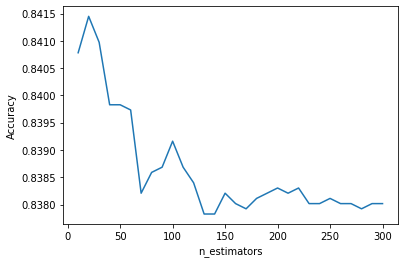

In [ ]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [ ]:
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

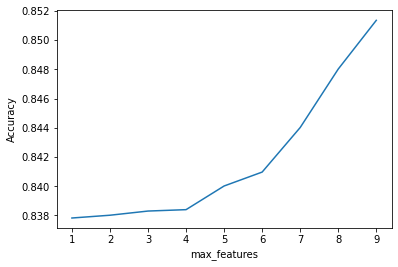

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 6

clf = XGBClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.9070045421945971, 0.8877020785219399)

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [ ]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
